## Modelling Penguins

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#### 1. Introduction
This project uses the Palmer Penguins dataset (https://allisonhorst.github.io/palmerpenguins/) to create two classification models for predicting species of penguins. We will first briefly explore the entire dataset through visualisations and performing an unsupervised analysis to highlight the most important aspects of the data. After that, we will then use what we learn to build a K-Nearest Neighbour and Decision Tree model and come to a conclusion
which best models the data.

#### 2. Exploration

The data consists of 344 data points with 8 features (excluding the ID number). The features are
described by categorical and numerical data types, with the ’species’ feature being made up of three
classes. We notice that upon an initial inspection we see some data points have missing values which
we proceeded to remove leaving us with 333 rows.

In [3]:
df_penguins = pd.read_csv('penguins.csv')
df_penguins.dropna(inplace=True)
df_penguins

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,6,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...,...
339,340,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,341,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,342,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,343,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [4]:
df_penguins.dropna(inplace=True)

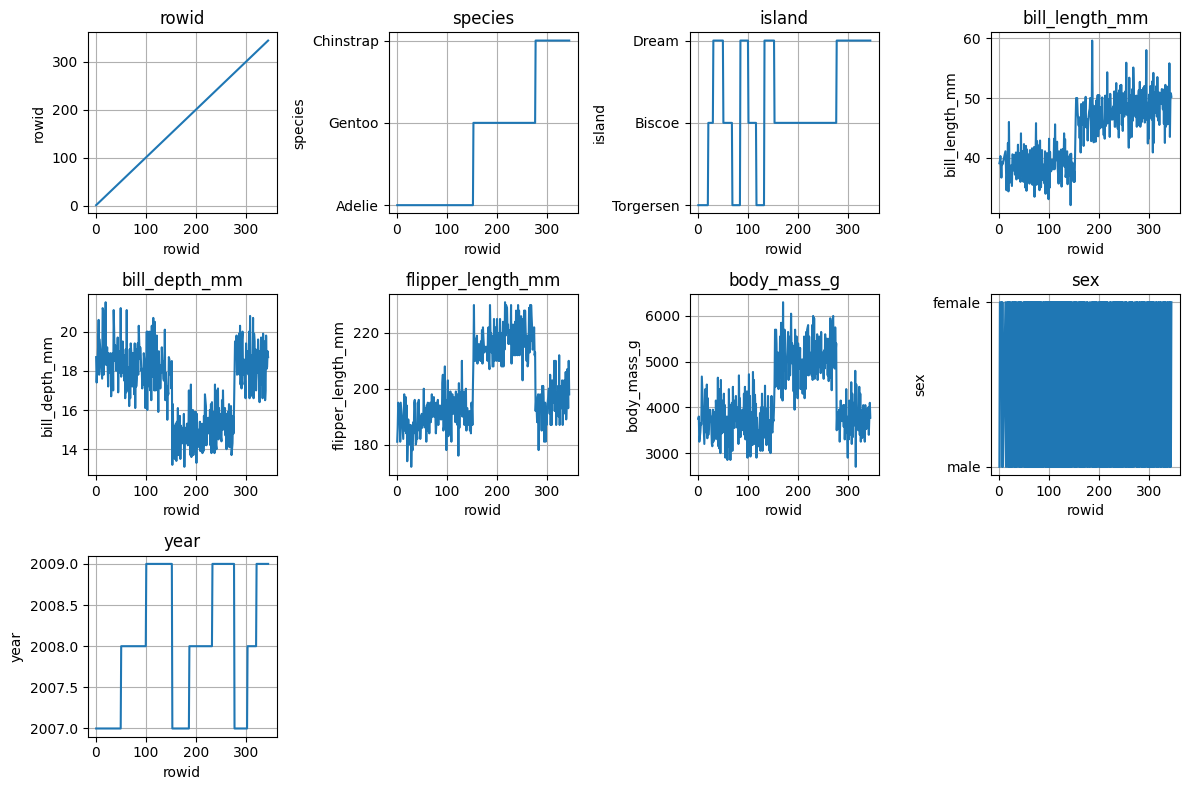

In [5]:
# Calculate the number of rows and columns for subplots
num_cols = 4 # Number of columns of subplots
num_rows = (len(df_penguins.columns) + num_cols - 1) // num_cols  # Number of rows of subplots


# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten()

# Plot each variable against the date column on separate subplots
for i, column in enumerate(df_penguins.columns):
    ax = axes[i]
    ax.plot(df_penguins['rowid'], df_penguins[column], linestyle='-')
    ax.set_title(column)
    ax.set_xlabel(df_penguins.columns[0])
    ax.set_ylabel(column)
    ax.grid(True)

# Hide unused subplots
for i in range(len(df_penguins.columns), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [6]:
# Clean the data
df_penguins.drop(['year', 'rowid'], axis=1, inplace=True)

After cleaning and learning how features are represented, we visualise data to understand the data
further. When we order the data by species, plots in figures above clearly show that the features which
describe the penguin’s anatomy are likely strong indicators for discerning a penguins species. The
only slight exception to this is the bill length which we see are similar for the Gentoo and Chinstrap
species. Also, we did not identify any significant outliers. Furthermore, we note that island does seems
to not be a large indicator for the Adelie penguins species. Finally, we also found that the feature
’year’ to not have much relevance, as it is likely a record of when the data was recorded, therefore we
drop this feature from our analysis.

##### 2.1 K-Means Clustering

To further learn about the data we constructed an unsupervised K-means model. This model was chosen as the ratio of species are not overwhelmingly imbalanced, and our dataset is small. In this model we included features ’bill length’, ’bill depth’, ’flipper length’, and ’body mass’ which are all numerically represented data. As a resulted, we used Euclidean distance as the metric to minimise in the algorithm. K-means can only easily be used when
one data type is used, so we excluded all the categorical data.

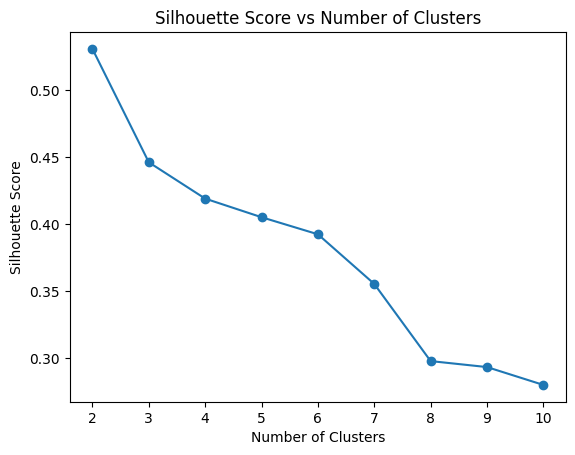

In [167]:
features = df_penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method and silhouette score
silhouette_scores = []
for k in range(2, 11):  # Trying cluster numbers from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_scores.append(silhouette_score(scaled_features, cluster_labels))

# Plot silhouette scores to determine the optimal number of clusters
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()


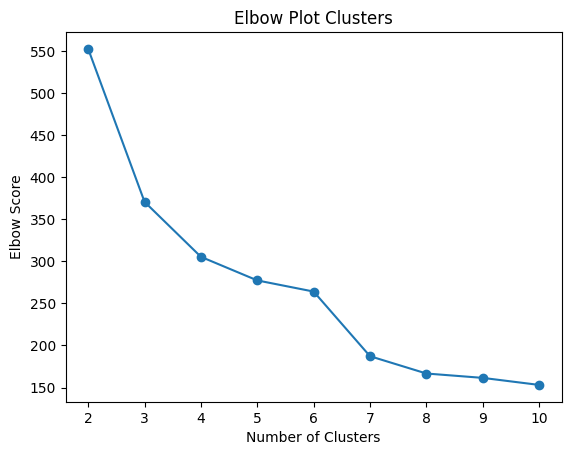

In [168]:
elbow_scores = []
for k in range(2, 11):  # Trying cluster numbers from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    elbow_scores.append(kmeans.inertia_)

# Plot elbow scores to determine the optimal number of clusters
plt.plot(range(2, 11), elbow_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Elbow Score')
plt.title('Elbow Plot Clusters')
plt.show()

To select the optimal number of clusters k we compute the elbow and silhouette scores for k = 2, ..., 10.
From the silhouette and elbow plots above we find that there is no clear elbow but rather two long elbows
separated at k = 6. We additionally see that for the silhouette plot the values from corresponding to
the first long elbow, k = 3 to k = 6, are higher so we could perhaps say these are better values than
k = 7, 8, 9, 10. Hence we select the highest number of clusters from the first elbow, as higher silhouette
scores indicate better clustering, k = 3.

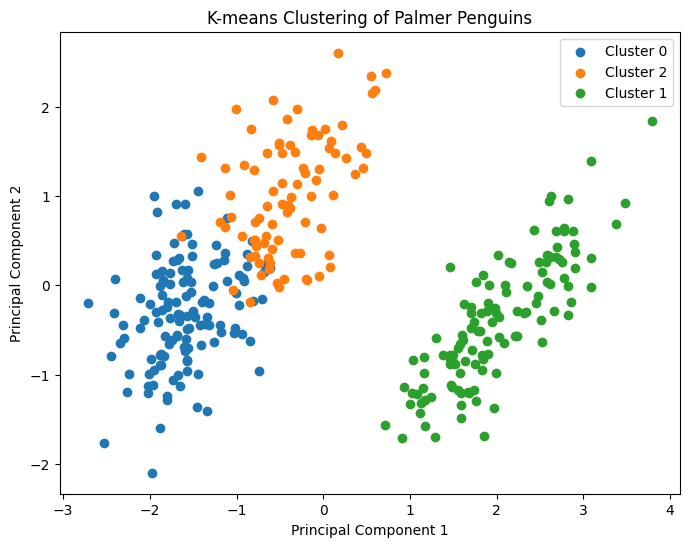

In [169]:
# Based on the plot, choose the optimal number of clusters (k)
# Let's assume we choose k = 3

# Perform K-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Visualize the clusters using PCA for dimensionality reduction and scatter plot
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Create a DataFrame with PCA features and cluster labels
clustered_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2'])
clustered_df['Cluster'] = cluster_labels

# Plot
plt.figure(figsize=(8, 6))
for cluster in clustered_df['Cluster'].unique():
    plt.scatter(clustered_df[clustered_df['Cluster'] == cluster]['PC1'],
                clustered_df[clustered_df['Cluster'] == cluster]['PC2'],
                label=f'Cluster {cluster}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of Palmer Penguins')
plt.legend()
plt.show()

Finally, we plot the results using K-means with principle dimensionality reduction, to reduce the
four dimensional feature space into two for visualisation. In the cluster plot above we observe that there are two
separate large clusters, with cluster 0 and 2 overlapping. From this K-means analysis we conclude
that potentially one species of penguins are clearly identifiable from the rest which may lie in cluster 1 . The other two species may share more similarities but can still be grouped.

#### 3. Baseline Model

Before discussing the results of the supervised models, we will first establish a baseline model. We
construct this model by simply taking the largest population type of penguin species T and saying
that for a given set of n unidentified penguins, we predict they are all of species T.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [36]:
X = df_penguins['species']
y = df_penguins['species']

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate the frequency of each penguin species in the training set
species_counts = X_train.value_counts()
print("Species Counts in Training Set:")
print(species_counts)

# Identify the most frequent species (majority class)
baseline_species = species_counts.idxmax()
print("\nBaseline Species (Majority Class):", baseline_species)

# Create baseline predictions for the test set
y_pred_baseline = [baseline_species] * len(y_test)

# Evaluate the baseline model
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print("\nAccuracy of Baseline Model (Majority Class):", accuracy_baseline)

Species Counts in Training Set:
species
Adelie       102
Gentoo        83
Chinstrap     48
Name: count, dtype: int64

Baseline Species (Majority Class): Adelie

Accuracy of Baseline Model (Majority Class): 0.44


#### 4. K-Nearest Neighbours

For our first supervised model, we chose to apply the K-nearest neighbours. We chose this method for similar reasons as to why we used K-means, our dataset is small so we do not need to worry about using computationally expensive algorithms. Even more, the method does not assume anything about the properties of the data. When it came to training features, we again used ’bill length’, ’bill depth’, ’flipper length’, and ’body mass’, as they best describe the anatomy of the penguin and we can not use mixed data types. We also again used Euclidean distance as the metric as we have numerical input features.

In [170]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
import seaborn as sns


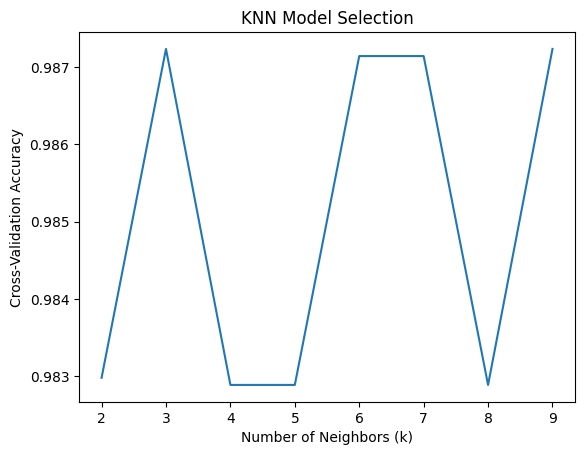

Optimal value of k: 3


In [171]:
# Split the data into features (X) and target (y)
X = df_penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = df_penguins['species']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Perform k-fold cross-validation to select optimal k
k_values = list(range(2, 10))
cv_scores = []

# Number of folds: 5
kf = KFold(n_splits=5, random_state=63, shuffle=True)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy', verbose=True)
    cv_scores.append(scores.mean())

# Plot the accuracy scores for different values of k
plt.plot(k_values, cv_scores)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('KNN Model Selection')
plt.show()

# Choose the best k based on cross-validation scores
best_k = k_values[cv_scores.index(max(cv_scores))]
print(f'Optimal value of k: {best_k}')


After performing training using k-fold cross validation for hyper-parameter k from 2 to 10, we obtain the accuracy results for each model. From the results we conclude that the number of neighbours 3,6,7,9 produce the highest performing models with training accuracy scores of around 0.987. However, it is also evident that all training accuracy’s for all values neighbours k are relatively high.

In [172]:
# Train the KNN model with the best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

# Visualize the results (for 2D features)
if X.shape[1] == 2:
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Predicted Species')
    plt.colorbar(label='Species')
    plt.show()

              precision    recall  f1-score   support

      Adelie       0.96      1.00      0.98        48
   Chinstrap       1.00      0.91      0.95        23
      Gentoo       1.00      1.00      1.00        29

    accuracy                           0.98       100
   macro avg       0.99      0.97      0.98       100
weighted avg       0.98      0.98      0.98       100



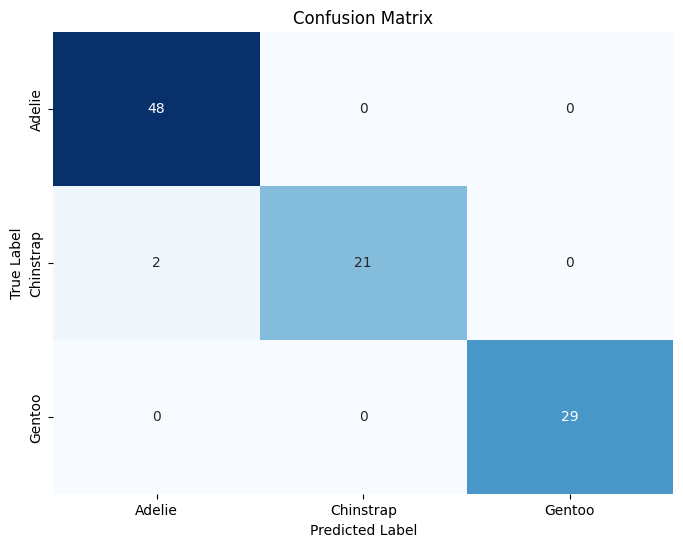

Classification Report:
               precision    recall  f1-score   support

      Adelie       0.96      1.00      0.98        48
   Chinstrap       1.00      0.91      0.95        23
      Gentoo       1.00      1.00      1.00        29

    accuracy                           0.98       100
   macro avg       0.99      0.97      0.98       100
weighted avg       0.98      0.98      0.98       100



In [173]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n", class_report)

#### 5. Decision Tree classification

So far all of the previous models only use the numerical data as inputs to train the model. To investigate if categorical features such as ’island’ or ’sex’ improved the accuracy, we wanted to use a model which could take mixed input data. Hence, for our second model we selected the Decision tree. The benefit of using this method also allows us visually see what indicators are most important for classifying penguins.

Our method for training this model remains largely the same as before however, we also incorporate the help of grid search to perform k-fold cross validation on all combinations of hyper-parameters and algorithm criterion.

In [174]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Encode categorical variables
df_penguins['species'] = df_penguins['species'].astype('category').cat.codes
df_penguins['island'] = df_penguins['island'].astype('category').cat.codes
df_penguins['sex'] = df_penguins['sex'].astype('category').cat.codes
df_penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,1
1,0,2,39.5,17.4,186.0,3800.0,0
2,0,2,40.3,18.0,195.0,3250.0,0
4,0,2,36.7,19.3,193.0,3450.0,0
5,0,2,39.3,20.6,190.0,3650.0,1
...,...,...,...,...,...,...,...
339,1,1,55.8,19.8,207.0,4000.0,1
340,1,1,43.5,18.1,202.0,3400.0,0
341,1,1,49.6,18.2,193.0,3775.0,1
342,1,1,50.8,19.0,210.0,4100.0,1


Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

Accuracy of Decision Tree Classifier with Best Parameters: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        48
           1       0.91      0.87      0.89        23
           2       1.00      0.97      0.98        29

    accuracy                           0.95       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.95      0.95       100



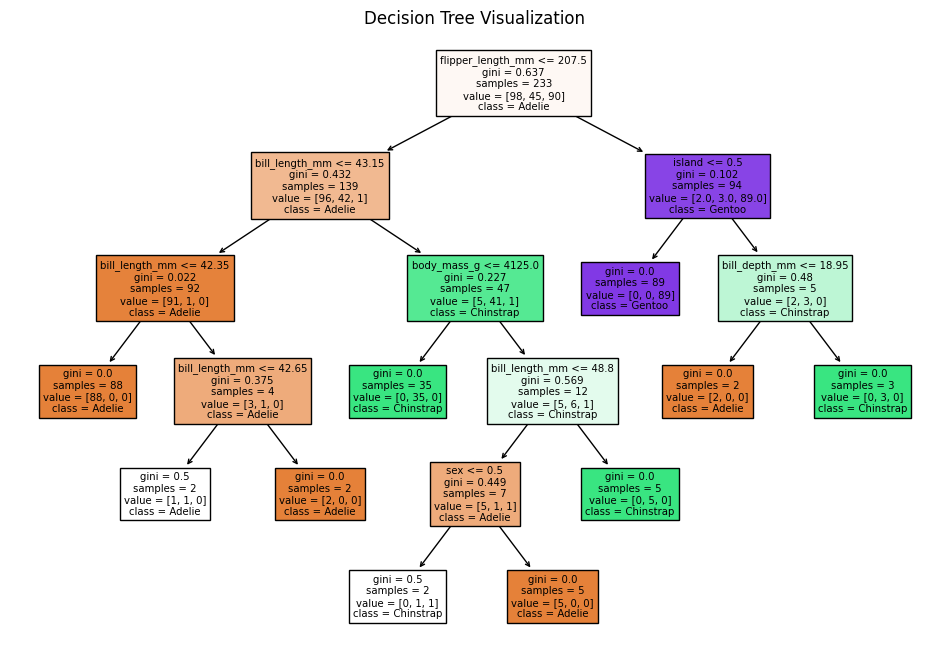

In [175]:
# Split the data into features (X) and target (y)
X = df_penguins.drop(['species'], axis=1)
y = df_penguins['species']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid for grid search
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 30],
    'min_samples_leaf': [1, 2, 4, 20]
}

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Instantiate GridSearchCV for decision tree
grid_search_dt = GridSearchCV(estimator=dt_classifier, param_grid=param_grid_dt, cv=5, scoring='accuracy')

# Perform grid search to find the best parameters
grid_search_dt.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search_dt.best_params_)

# Get the best decision tree estimator
best_dt_classifier = grid_search_dt.best_estimator_

# Predict on the test set using the best estimator
y_pred_dt_best = best_dt_classifier.predict(X_test)

# Evaluate the model
accuracy_dt_best = accuracy_score(y_test, y_pred_dt_best)
print("\nAccuracy of Decision Tree Classifier with Best Parameters:", accuracy_dt_best)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt_best))

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_dt_classifier, feature_names=X.columns, class_names=['Adelie', 'Chinstrap', 'Gentoo'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()


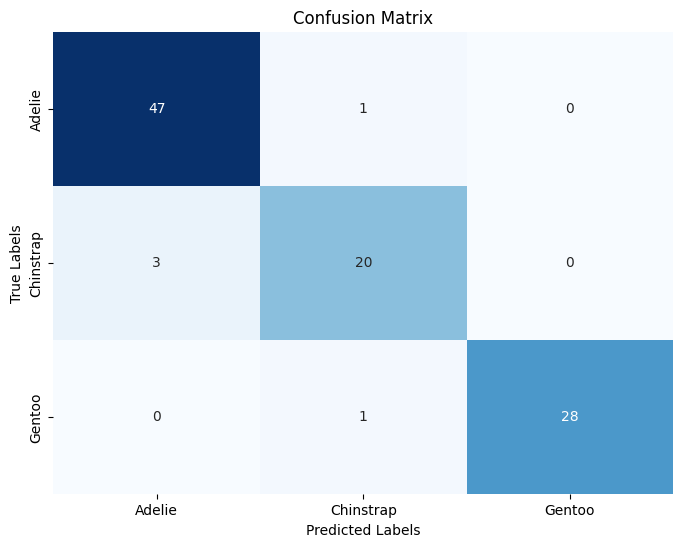

In [176]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt_best)
class_names = ['Adelie', 'Chinstrap', 'Gentoo']
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, yticklabels=class_names, xticklabels=['Adelie', 'Chinstrap', 'Gentoo'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### 6. Discussion

To start this discussion, we note that both the KNN and Decision tree both perform very well at classifying penguin species, and outperformed the baseline significantly. Both supervised models also saw marginal drops in accuracy when going from the training to the test data sets, instilling confidence that our models are not over-fitting. As mentioned previously, one of the reasons we chose the KNN and Decision Tree models was so that we could compare if using all of the mixed data improved classification accuracy over just using the anatomical numerical data. Although both models performed extremely well, we can conclude that this perhaps is not the case, as KNN marginally beats the Decision Tree on the unseen data.

On the other hand, the Decision Tree still provided us we some interesting insight into the strongest indicators for determining penguin species. From the Decision tree plot we can see that flipper length ≤207.5mm, island, and bill length ≤43.15mm are the top three indicators. 